In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 46
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [6]:
experiment_name = "semi_sup_gaussian_mah_k10"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=8,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

In [9]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=2,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models

# Read the latent vectors for train data

In [10]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=46 z_min=-4.0438013 z_max=4.3203773000000005
Latent vectors shape (59840, 10)


In [11]:
os.path.join(exp_config.ANALYSIS_PATH, filename)


'/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/z_train_128_32_10_epoch_6.csv'

# Load training images,  labels and manual annotations

In [12]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior with uniform distribution
Number of samples with manual annotation 0.0


In [13]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 6.0


# Use Elbow method to to find out number of optimum clusters k

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


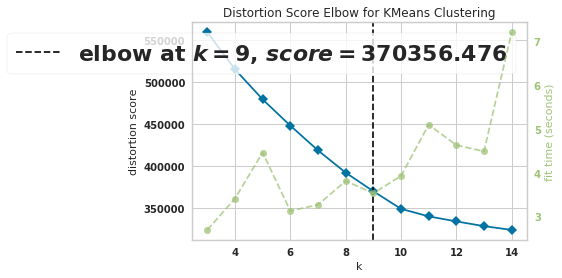

In [28]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [29]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [14]:
num_clusters=10

In [15]:
manual_annotation_file_json

NameError: name 'manual_annotation_file_json' is not defined

In [16]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [21]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [9, 1, -1, 2
                                               0, 7, 1, 6,
                                               3, 8
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8, 1, 0, 0.8,
                                                  1, 0.7, 1, 0.9,
                                                  0.8, 0.8]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [23]:
manual_labels

[7, 2, 6, 8, -1, 1, 3, 0, 9, 5]

In [17]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [18]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [19]:
cluster_group_dict

{None: <clearn.analysis.ClusterGroup at 0x7fe47d4d0c10>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fe450ec3950>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7fe450d12c90>}

In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


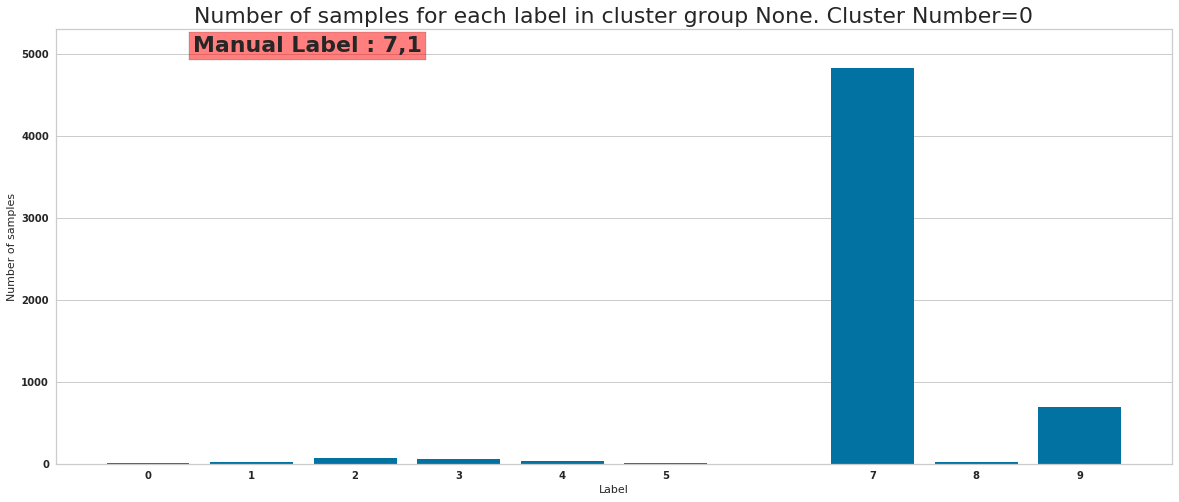

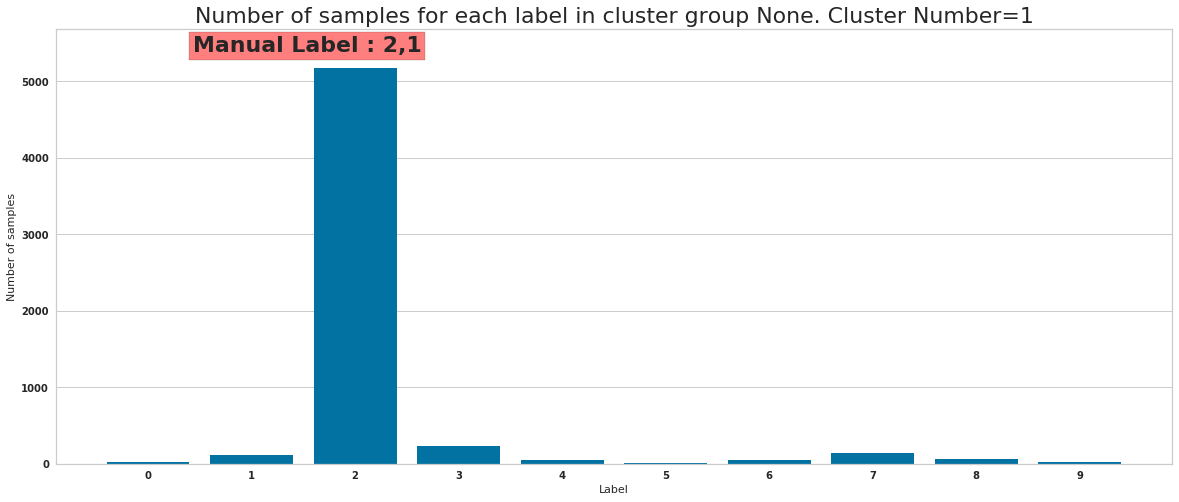

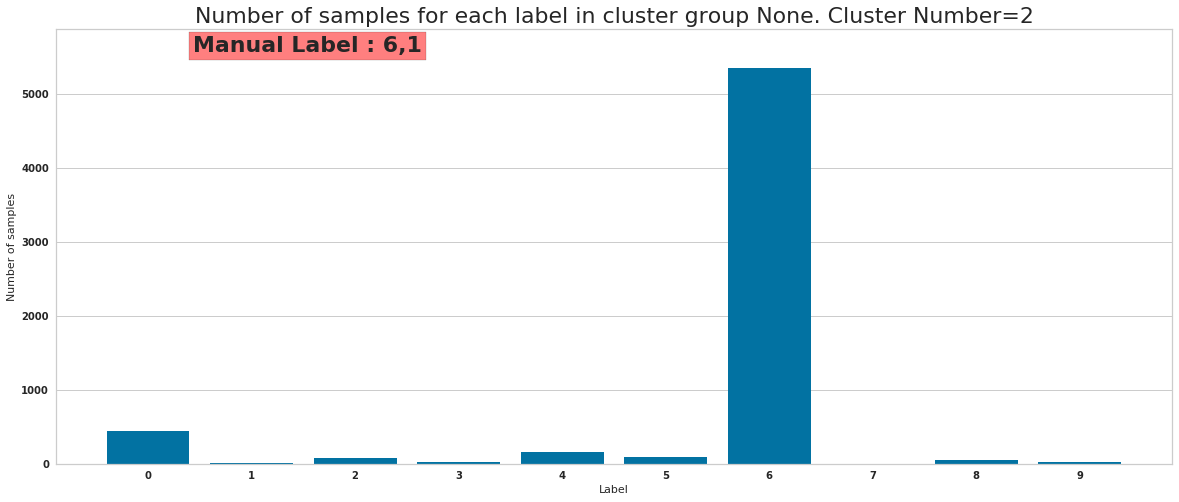

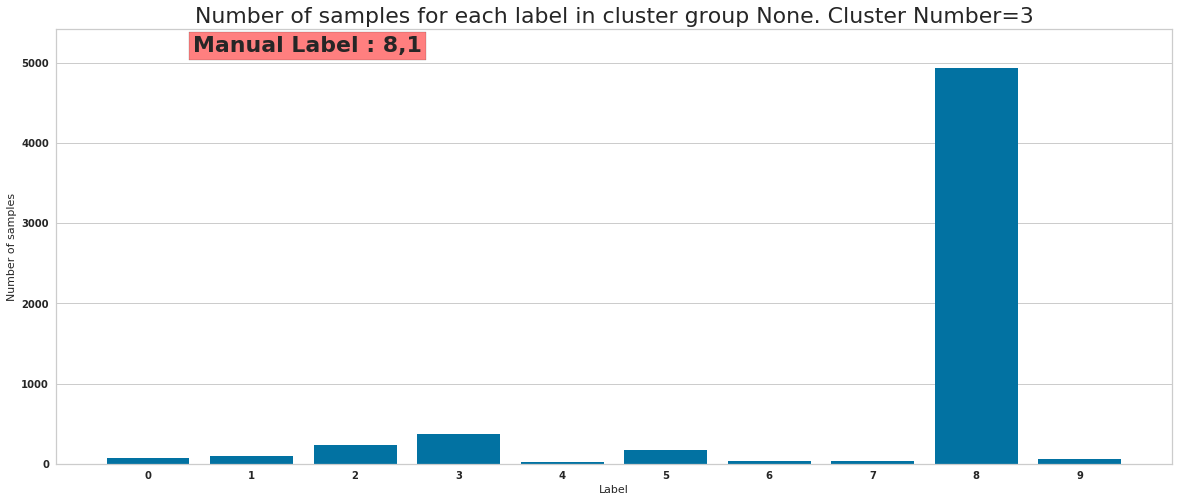

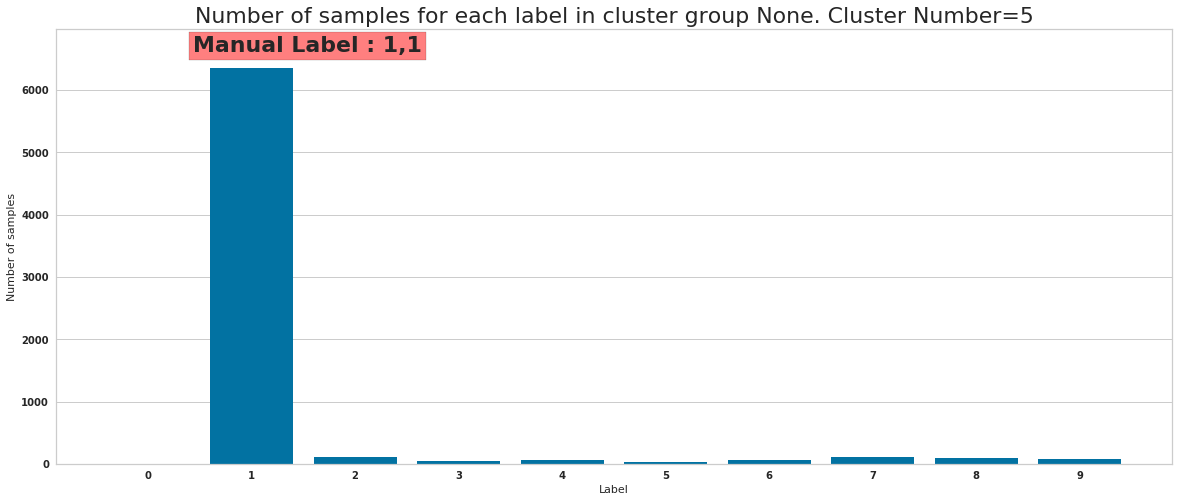

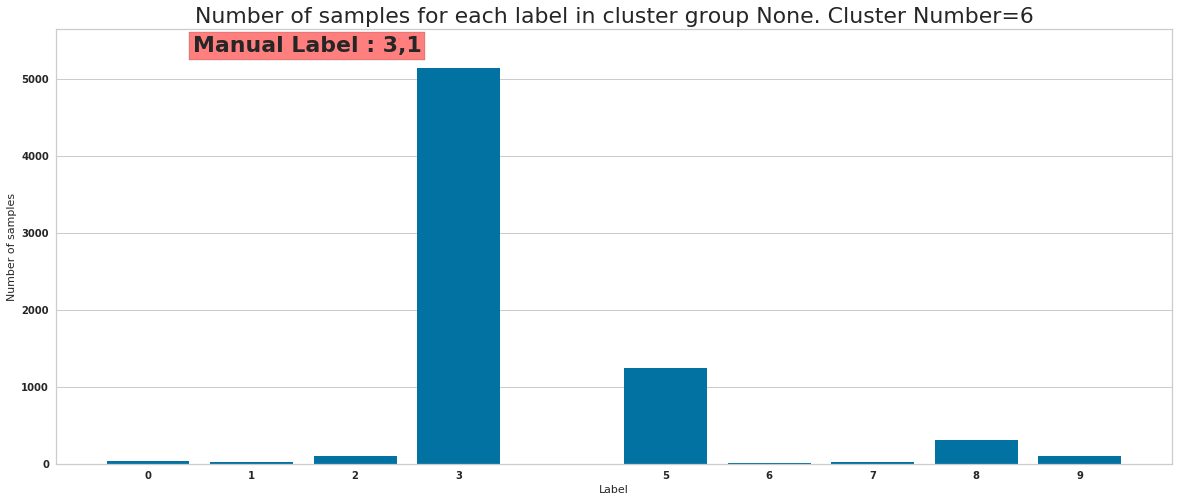

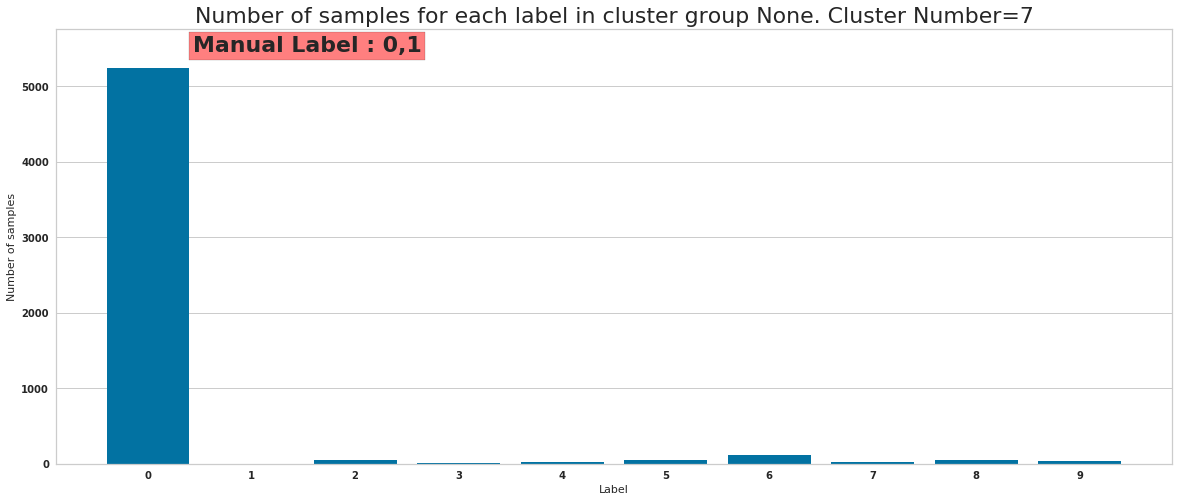

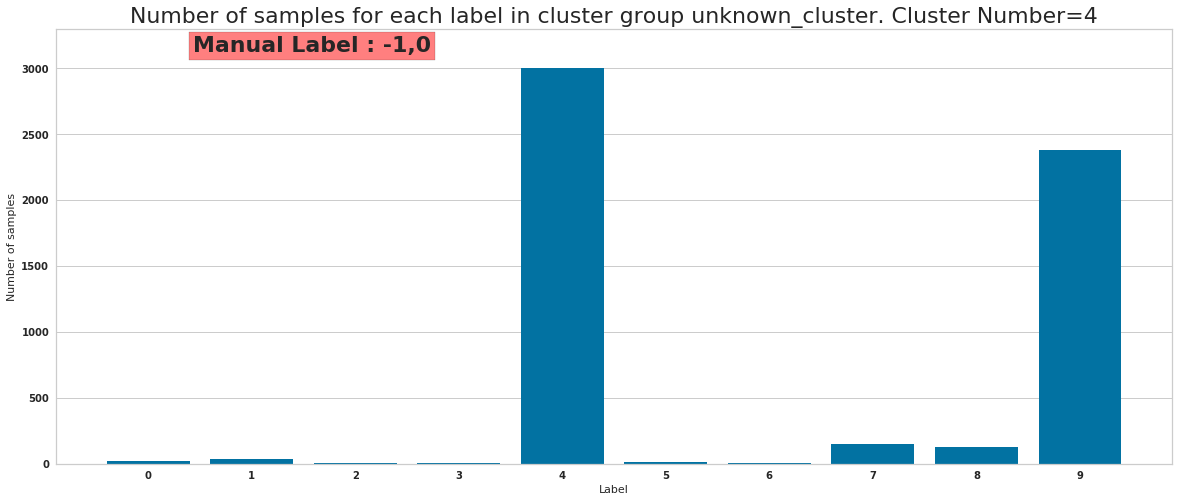

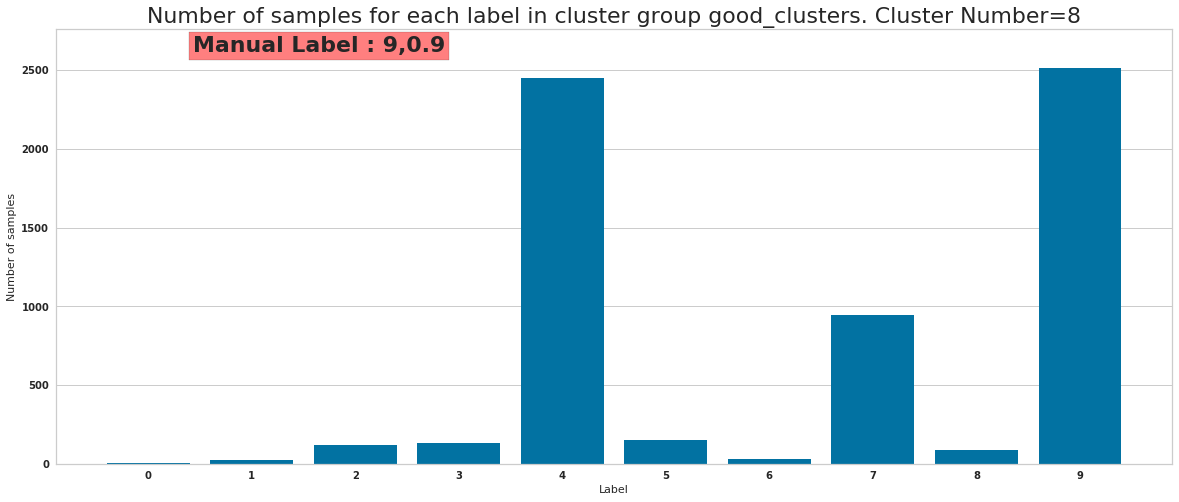

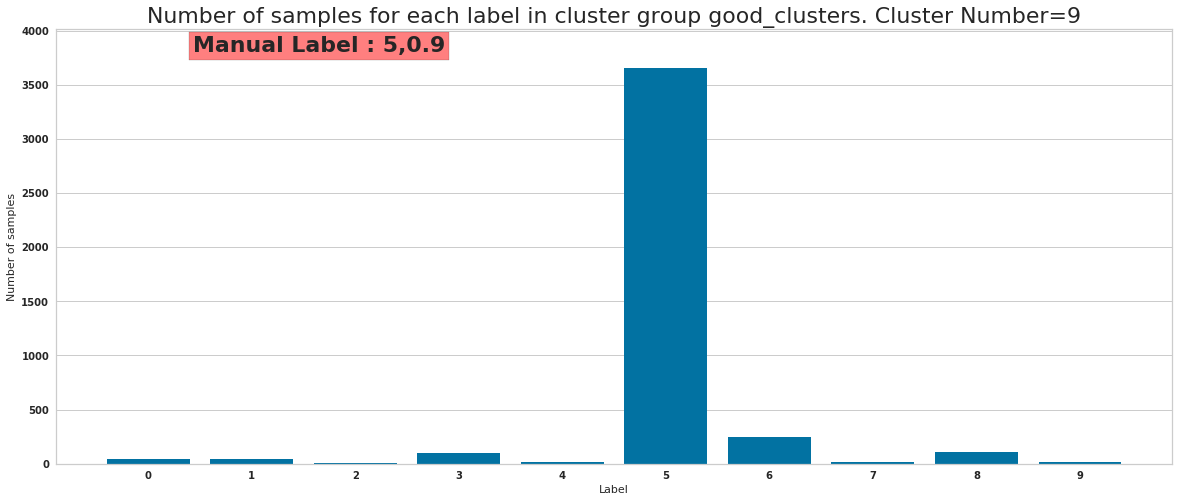

In [21]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [22]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5727, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5883, 10)
(6257, 10)
(6031, 10)
(5737, 10)
(6917, 10)
(6977, 10)
(5608, 10)
(6454, 10)
(4249, 10)


In [23]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9'],
      dtype='object')

In [24]:
df[df["cluster_level_1"] == 4].shape

(5737, 43)

In [25]:
df[(df["cluster_level_1"] == 4) & (df["label"] == 9) ].shape

(2379, 43)

In [26]:
lv_9_9 = df[(df["cluster_level_1"] == 4) & (df["label"] == 9) ][z_col_names].values
lv_9_9.shape

(2379, 10)

In [27]:
lv_4_9 = df[(df["cluster_level_1"] == 4) & (df["label"] == 4) ][z_col_names].values
lv_4_9.shape

(2999, 10)

In [28]:
from clearn.analysis.cluster_utils import decode_latent_vectors

In [29]:
tf.reset_default_graph()
images_4_9 =  decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                          lv_4_9,
                          exp_config,
                          dao)


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_6

In [30]:
images_4_9.shape

(2999, 28, 28, 1)

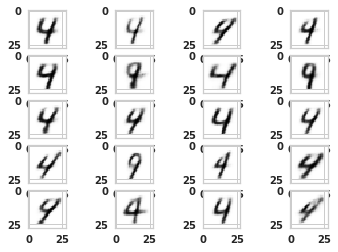

In [31]:
display_cluster_center_images(images_4_9[0:20, :, :, :], "images_4_9.png", images_4_9[0:20, :])


In [32]:
indices_0 = df["cluster_level_1"].values == 0
print(indices_0.shape)
indices_9 = df["label"].values == 4
print(indices_9.shape)

lv_4_9_indices_bool = indices_0 & indices_9
lv_4_9_indices = np.where(lv_4_9_indices_bool)[0]
print(lv_4_9_indices.shape)
images_4_9_orig = images[lv_4_9_indices,:,:,:]

(59840,)
(59840,)
(29,)


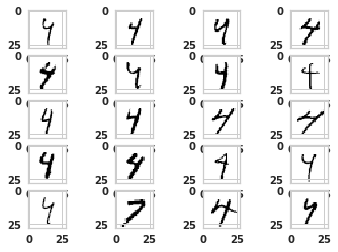

In [33]:
display_cluster_center_images(images_4_9_orig[0:20, :, :, :], "images_4_9.png", images_4_9_orig[0:20, :])


In [34]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0


def get_min(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.min(axis=0)
    return mu_0


def get_max(i,df,mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.max(axis=0)
    return mu_0

mu_mean = []
mu_min = []
mu_max =[]
for i in unique_labels:
    mu_mean.append( get_mean(i, df,z_col_names) )
    mu_min.append( get_min(i, df,z_col_names) )
    mu_max.append( get_max(i, df,z_col_names) )


In [35]:
def trace(exp_config, trace_from, trace_to, mu_mean, num_trace_steps, d):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, d ] = alpha_i * mu_mean[trace_to][d] + (1 - alpha_i) * mu_mean[trace_from][d]
    return z
    
    

In [36]:
d = list(range(len(unique_labels)))
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

        
    total_latent_vectors = len(unique_labels) + (len(unique_labels) - 1) * num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    for i in range(len(mu_mean)):
        z[i, :] = mu_mean[i]
    num_latent_vectors = len(mu_mean)
        
    for label_index in range(len(unique_labels) - 1):
        traced_from_to = trace(exp_config, label_index, label_index + 1, mu_mean, num_trace_steps, d)
        for i in range(num_trace_steps):
            z[ num_latent_vectors, :] = traced_from_to[i]
            num_latent_vectors += 1
    reconstructed_images = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

In [37]:
d = list(range(len(unique_labels)))
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

        
    total_latent_vectors = num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    num_latent_vectors = 0
    label_index_from = 4
    label_index_to = 9
    traced_from_to = trace(exp_config, label_index_from, label_index_to, mu_mean, num_trace_steps, d)
    for i in range(num_trace_steps):
        z[ num_latent_vectors, :] = traced_from_to[i]
        num_latent_vectors += 1
    reconstructed_images_4_9 = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

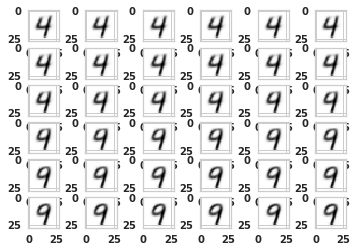

In [38]:
colormap="Greys"
num_images_plotted =0 
title_string = "Images obtained by gradually changing \n the latent vector digit {} to {}"
j = 4
fig = plt.figure()
# fig.suptitle(title_string.format(4, 9))
for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
    ax = fig.add_subplot(6, 6, i-num_images_plotted + 1)
    ax.imshow(np.squeeze(reconstructed_images_4_9[i]), cmap=colormap)
num_images_plotted += num_trace_steps
#plt.savefig(ANALYSIS_PATH+"trace_path_{}.png".format(j))

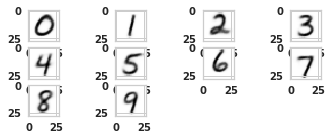

In [39]:
colormap = "Greys"
figure = plt.subplot(3, 3, 1)
for i in range(len(unique_labels) ):
    plt.subplot(6, 4, i+1)
    plt.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)

In [40]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0

In [41]:
def plot_latent_vector(df, labels):
    figure = plt.figure(figsize=(20,10))
    for label in labels:
        mu_mean = get_mean(label, df,mean_col_names)
        plt.plot(mu_mean, label=f"Mean {label}")
    plt.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.xticks(list(range(exp_config.Z_DIM)))
    plt.grid(which="major",axis="both")
    plt.title("Mean of Latent vector")


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


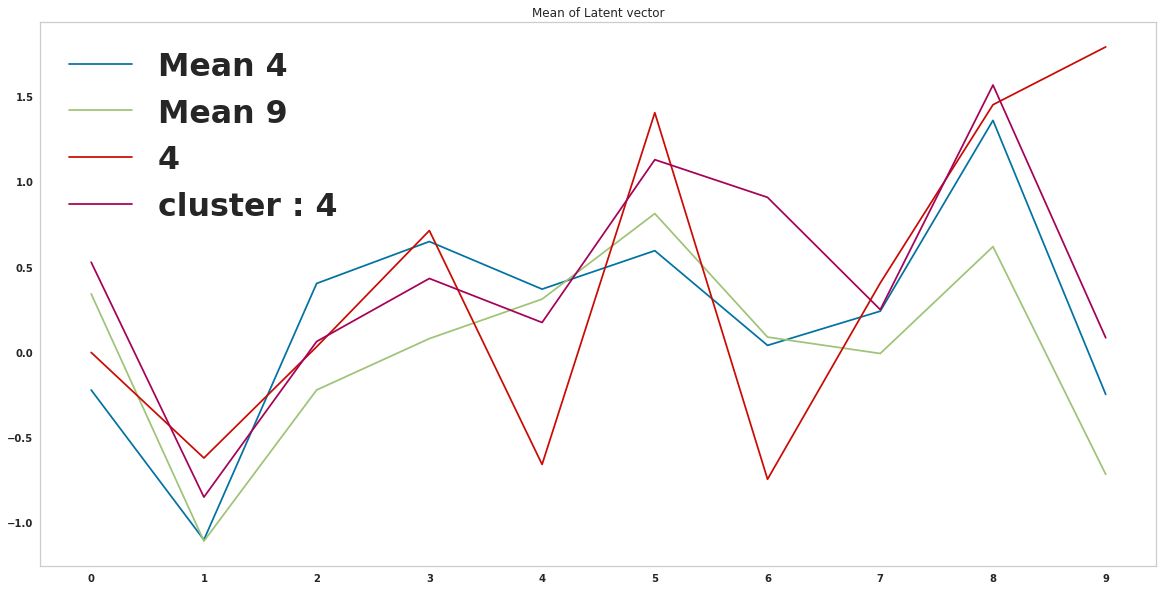

In [42]:
plot_latent_vector(df, [4, 9])
plt.plot(lv_4_9[19, :], label=str(4))
plt.plot(cluster_centers[4,:], label=f"cluster : {4}")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')


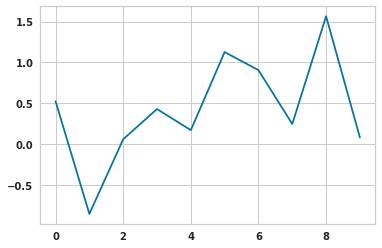

In [43]:
plt.plot(cluster_centers[4])

In [44]:
def trace_dim(exp_config, mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z
    
    

In [45]:
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    num_latent_vectors = 0
    total_latent_vectors = len(unique_labels) * exp_config.Z_DIM * num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    for d in range(10):
        for dimension in range(exp_config.Z_DIM):
            traced_from_to = trace_dim(exp_config, mu_mean[d], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[ num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
    reconstructed_images = decode(model, z, exp_config.BATCH_SIZE)
    
    z = np.zeros([exp_config.BATCH_SIZE, exp_config.Z_DIM])
    for i in range(10):
        z[i,:] = mu_mean[i]
    reconstructed_images_mean = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

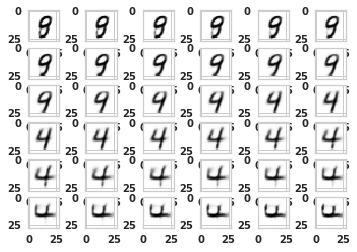

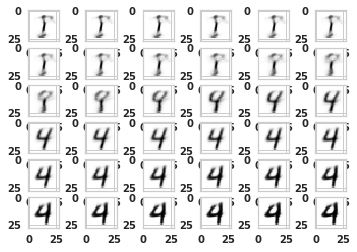

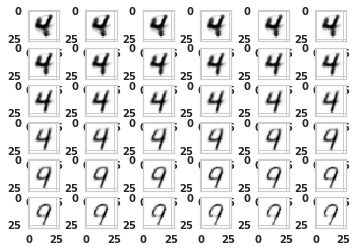

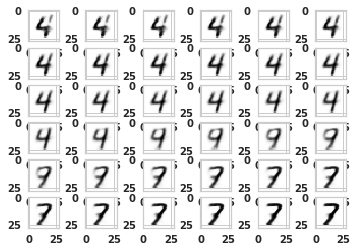

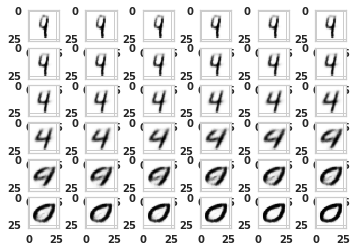

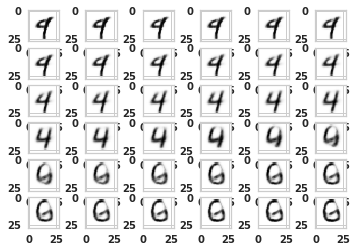

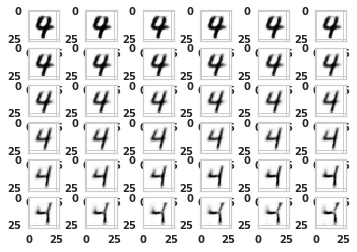

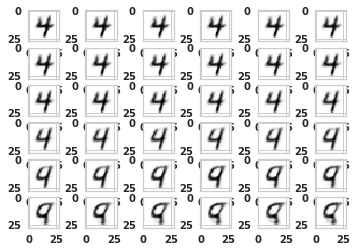

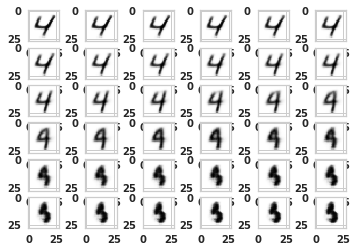

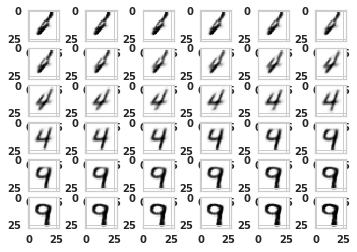

In [46]:
d = 4

num_images_plotted = d * exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    #fig.suptitle(title_string.format(dim,d))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

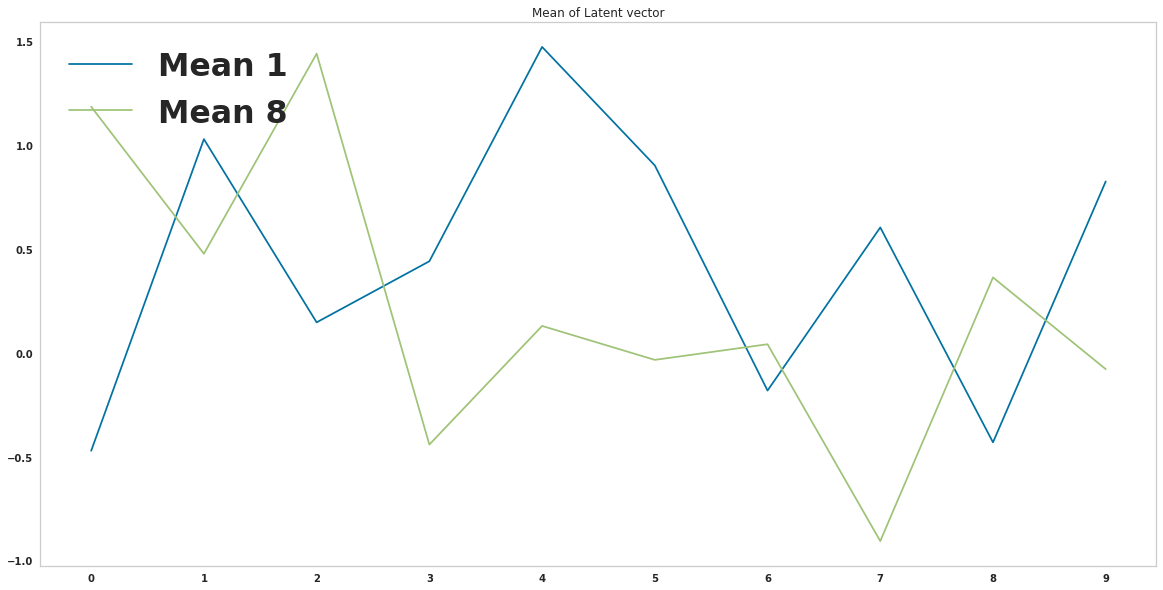

In [47]:
plot_latent_vector(df, [1, 8])

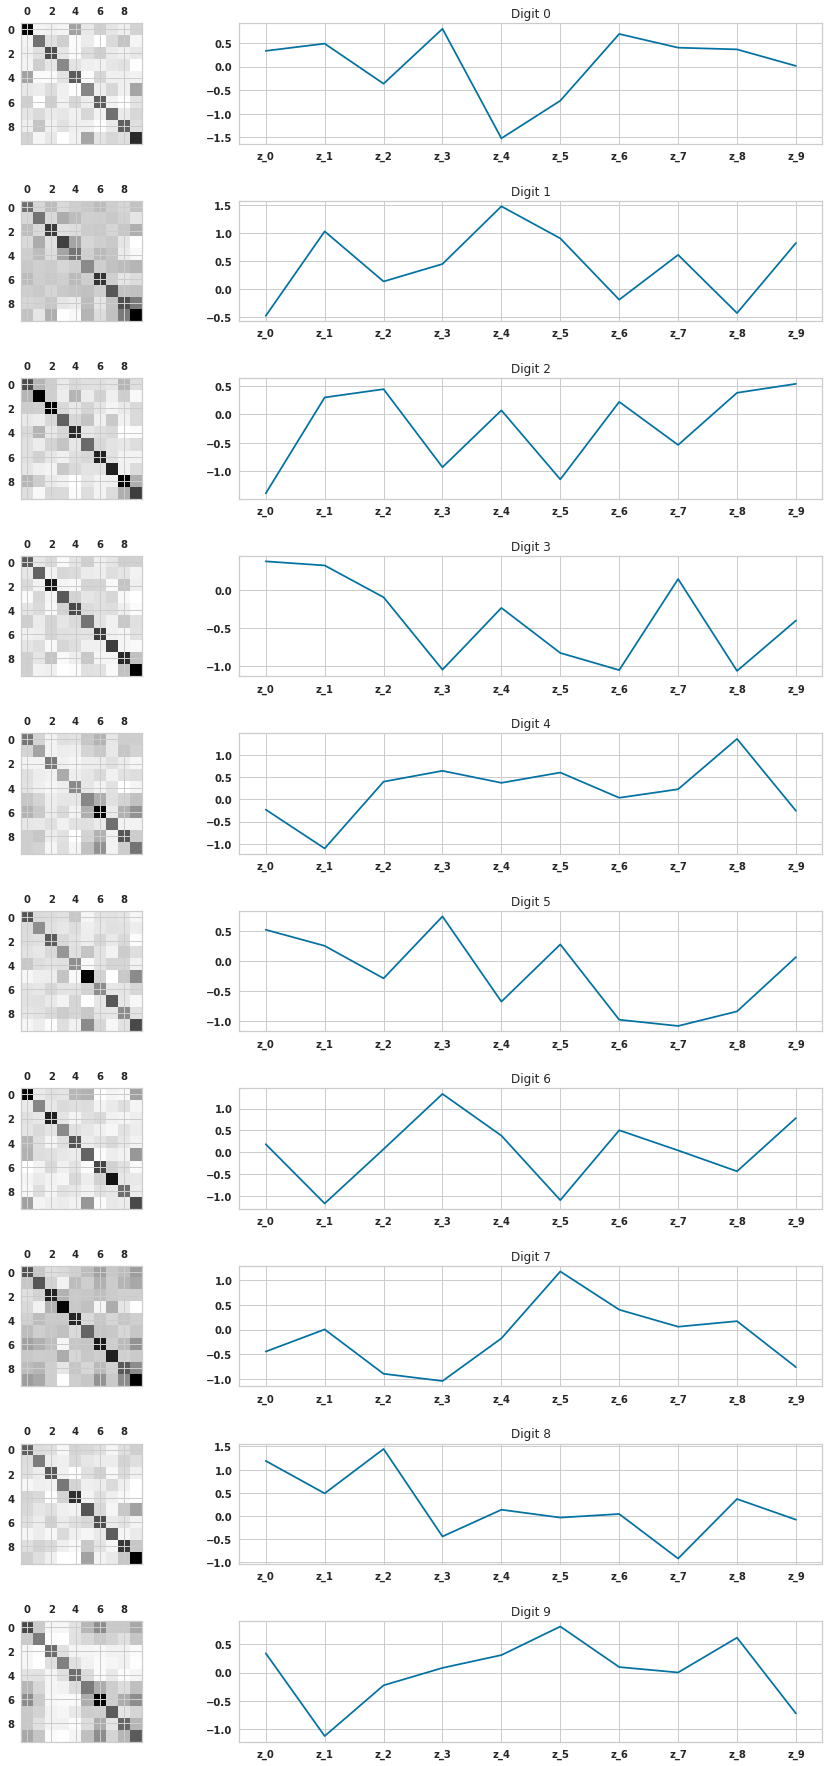

In [48]:
fig = plt.figure(figsize=(15,25))
#fig.tight_layout()

for i in range(exp_config.Z_DIM):
    lv = df_0 = df[df["label"] == i][z_col_names]
    covar = np.cov(np.transpose(lv))

    ax = fig.add_subplot(10, 2, i * 2 + 1 )
    ax.matshow(covar)
    #fig.colorbar(ax)
    #ax.xticks([])
    ax1 = fig.add_subplot(10, 2, i * 2 + 2)
    ax1.plot(np.mean(lv))

    plt.title(f"Digit {i}")
    plt.tight_layout()


In [50]:
from sklearn.manifold import TSNE

In [51]:
lv_4_and_9 = df[(df["label"] == 4) | (df["label"] == 9) ][z_col_names].values
lv_4_and_9.shape


(11760, 10)

In [52]:
X_embedded = TSNE(n_components=2).fit_transform(lv_4_and_9)


In [54]:
df_subset = df[(df["label"] == 4) | (df["label"] == 9) ]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


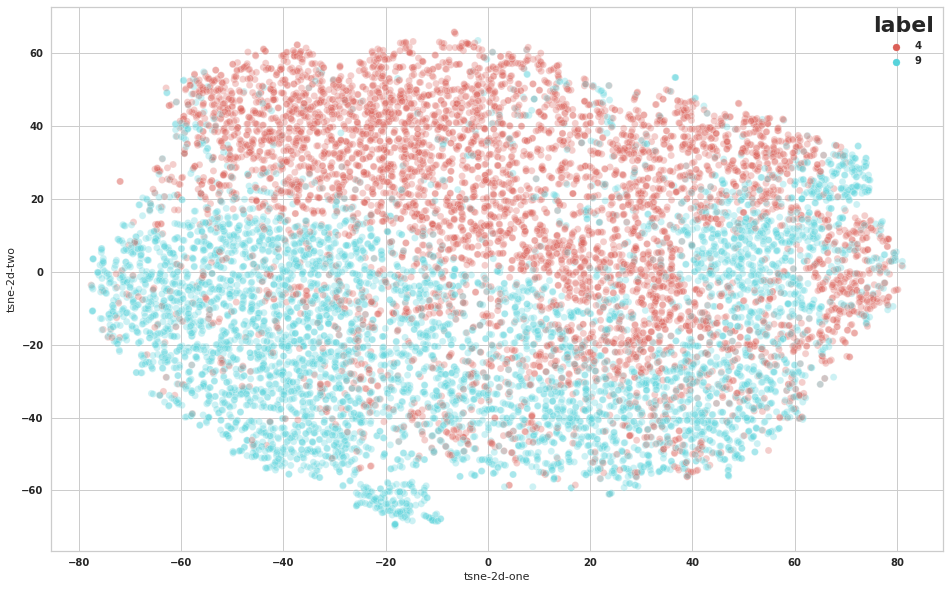

In [56]:
import seaborn as sns

df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [57]:
lv = df[z_col_names].values
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(lv)


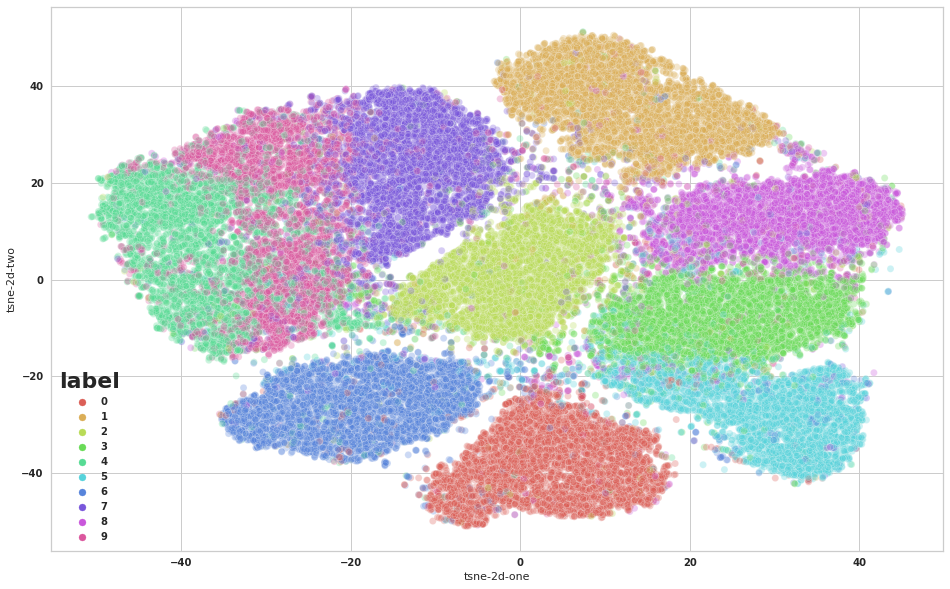

In [59]:

df['tsne-2d-one'] = X_embedded[:,0]
df['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
lv = df[z_col_names].values
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(lv)
